# Introduction

        In the contemporary research landscape, deep learning has emerged as a pivotal tool for various applications, including text classification. This study aims to construct a deep learning architecture, employing Bidirectional Recurrent Neural Networks (BRNNs), Gated Recurrent Units (GRUs), and Long Short-Term Memory (LSTM) networks, to effectively classify textual data. The dataset, integral to this research, encompasses texts annotated with binary labels, either 0 or 1.

        These labels have distinct connotations in the context of disasters. Specifically, texts labeled with 0 signify the absence of any indicators pointing to ongoing disasters, whereas those marked with 1 serve as an explicit confirmation of the occurrence of incidents. By leveraging the power of BRNNs, GRUs, and LSTMs, this study seeks to develop a robust text classification model that can accurately discern the presence or absence of emergency incidents from the analyzed textual data.

# Necessary Imports

In [1]:


import tensorflow as tf
tf.__version__



'2.10.0'

In [2]:
import nltk
import re

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string

from nltk import stem
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from string import digits

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, LeakyReLU, Bidirectional, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, regularizers, optimizers, metrics
from sklearn.metrics import f1_score

from keras import layers
from tensorflow import keras
from tensorflow.compat.v1.keras.layers import CuDNNGRU as gru

tf.__version__

'2.10.0'

In [3]:
pd.set_option('display.max_colwidth', 600)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA

In [4]:
train[train['target']==1]['target'].isnull().sum()
train[train['target']==0]['target'].isnull().sum()
print('train shape is equal to', (train.shape[0],  train.shape [1]))
print('there is', train[train['target']==1]['target'].isnull().sum() , 'null values in target equal to 1' )
print('there is', train[train['target']==0]['target'].isnull().sum() , 'null values in target equal to 0' )

train shape is equal to (7613, 5)
there is 0 null values in target equal to 1
there is 0 null values in target equal to 0


In [5]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
train['length'] = train['text'].apply(len)
train = train.drop(['keyword', 'location'], axis = 1)
train

,id,text,target,length
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,Forest fire near La Ronge Sask. Canada,1,38
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83
7609,10870,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65
7611,10872,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137


In [7]:
train.shape

(7613, 4)

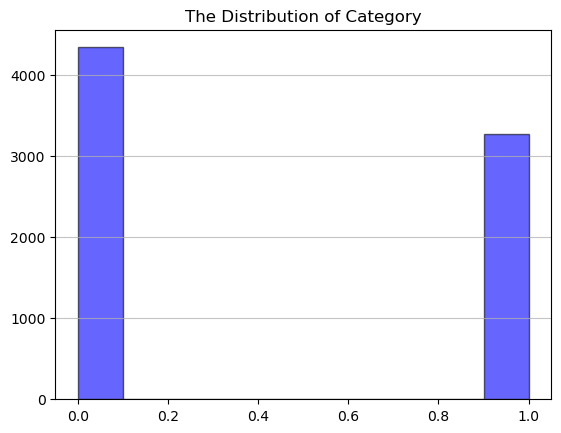

0    4342
1    3271
Name: target, dtype: int64


In [8]:
plt.hist(train.target ,density = 0, edgecolor='k', color ='blue', alpha = 0.6)
plt.grid(axis='y', alpha=0.75)
plt.title("The Distribution of Category")
plt.show()
print(train.target.value_counts())

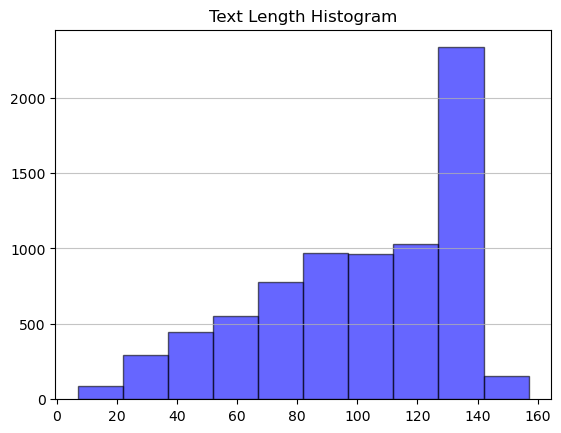

In [9]:
plt.hist(train['length'] ,density = 0, edgecolor='k',  color ='blue', alpha = 0.6)
plt.title("Text Length Histogram")
plt.grid(axis='y', alpha=0.75);
plt.show()

# Preprocessing

        The tokenize function presented herein is devised to process and preprocess textual data, facilitating its subsequent analysis. By incorporating various optional parameters, the function offers flexibility in addressing specific requirements. These parameters include the choice of text processing mode ('lemma', 'stem', or 'word'), the decision to eliminate stop words, and the option to convert all tokens to lowercase.
        Based on the chosen mode, the function conducts stemming, word filtering, or lemmatization. For each mode, the function returns a modified version of the text, comprising either stemmed words, filtered words, or lemmatized words. In the case where stop word removal is not desired, the function processes the text accordingly and returns the appropriately transformed output.

In [10]:
def tokenize(text , mode = 'lemma', stop_words = 'yes', lower_case = 'yes'):
    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # Remove Twitter handles
    text = re.sub(r"@\w+", "", text)

    # Remove hashtags
    text = re.sub(r"#", "", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove non-ASCII characters
    text = re.sub(r"[^\x00-\x7F]+", "", text)

    # Handle contractions
    contractions = {"'s ": " is", "'re": " are", "n't ": " not", "'ve ": " have", "'ll": " will", "'d ": " would", "'m ": " am", "'em ": " them"}
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)

    # Remove punctuation and digits
    text = re.sub(r"[{}]".format(string.punctuation + string.digits), " ", text)
    
    if stop_words == 'yes':
        remove_digits = str.maketrans('', '', digits)
        lemm = stem.WordNetLemmatizer()
        stop_words = nltk.corpus.stopwords.words('english')
        tokens = [word for word in nltk.word_tokenize(text) if len(word)>2]        #get all words with len>3 from the text as a token
        
        if lower_case == 'yes':
            tokens = map(str.lower , tokens)                                           #apply lower case letters to all tokens 
        if mode == 'stem':
            stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
            return " ".join(stems)
        elif mode == 'word':
            words = [word for word in tokens if (item not in stop_words)]
            return " ".join(words)
        elif mode == 'lemma':
            lemma = [lemm.lemmatize(item.translate(remove_digits)) for item in tokens if (item not in stop_words) ]
            return " ".join(lemma)

    elif stop_words == 'no':
        remove_digits = str.maketrans('', '', digits)
        tokens = [word for word in nltk.word_tokenize(text) if len(word)>2]         #get all words with len>3 from the text as a token
        if lower_case == 'yes':
            tokens = map(str.lower , tokens)                                            #apply lower case letters to all tokens 
        if mode == 'stem':
            stems = [stemmer.stem(item) for item in tokens]
            return " ".join(stems)
        elif mode == 'word':
            words = [word for word in tokens]
            return " ".join(words)
        elif mode == 'lemma':
            lemma = [lemm.lemmatize(item.translate(remove_digits)) for item in tokens]
            return " ".join(lemma)

In [11]:
# apply preprocessing functions on the train and test datasets
train['token'] = train['text'].apply(tokenize)
train

,id,text,target,length,token
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,deed reason earthquake may allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,38,forest fire near ronge sask canada
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,resident asked shelter place notified officer evacuation shelter place order expected
3,6,"13,000 people receive #wildfires evacuation orders in California",1,65,people receive wildfire evacuation order california
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,got sent photo ruby alaska smoke wildfire pours school
...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83,two giant crane holding bridge collapse nearby home
7609,10870,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125,control wild fire california even northern part state troubling
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65,utc volcano hawaii
7611,10872,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137,police investigating bike collided car little portugal bike rider suffered serious non life threatening injury


In [12]:
words = pd.Series(''.join(train.token).split())
word_count = words.value_counts()
word_count

amp             330
like            290
fire            272
get             210
one             157
               ... 
clipblack         1
destroyedsay      1
silas             1
sliced            1
injurylatest      1
Length: 17771, dtype: int64

In [13]:
word_count = pd.DataFrame(data=word_count, columns = ['count'])
word_count['word'] = word_count.index
word_count.index = range(1,word_count.shape[0]+1)
word_count[:50]
#sns.barplot(data=word_count)


,count,word
1,330,amp
2,290,like
3,272,fire
4,210,get
5,157,one
6,153,people
7,134,body
8,134,emergency
9,125,disaster
10,125,time


In [14]:
'''sns.countplot(data = word_count, x=word_count['word'])
plt.show()'''

"sns.countplot(data = word_count, x=word_count['word'])\nplt.show()"

In [15]:
tokenizer = Tokenizer(oov_token="oov", num_words=18000)
tokenizer.fit_on_texts(train["text"])
len(tokenizer.word_index)


22701

# Building Models

        In the pursuit of optimal model performance, various architectural parameters can be explored and fine-tuned to construct a robust architecture capable of achieving a high F1 score. The primary objective is to identify the best-performing model through comparative analysis and subsequently utilize this model for evaluating test scores.

        One crucial step in this process is the tokenization of the data. It is worth noting that state-of-the-art natural language processing (NLP) models currently tend to retain stopwords in the text, as these words contribute valuable contextual information. However, in order to simplify the analysis and streamline the process, stopwords will be removed in this particular study. This decision may impact the overall model performance and is a trade-off that should be carefully considered in the context of the specific problem being addressed

#### Train-Validation Split

In [16]:
Xtrain, Xval, ytrain, yval = train_test_split(train["text"], train["target"], test_size=0.15)
Xtrain=tokenizer.texts_to_sequences(Xtrain)
Xtrain = pad_sequences(sequences=Xtrain, maxlen=50)

Xval=tokenizer.texts_to_sequences(Xval)
Xval = pad_sequences(sequences=Xval, maxlen=50)

In [17]:
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val)
        y_pred = (y_pred > 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        logs['val_f1_score'] = f1
        self.f1_scores.append(f1)
        print(f' - val_f1_score: {f1:.4f}')
        
    def plot_f1_scores(self):
        plt.plot(self.f1_scores)
        plt.grid(True, color = 'gray')
        plt.title('F1 Score vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.show()
        
def evaluate_model(model ,lr, epoch):
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", 'AUC'])
    f1_score_callback = F1ScoreCallback(Xval, yval)
    modelfit = model.fit(Xtrain, ytrain, 
                         validation_data=(Xval, yval),
                         epochs=epoch,
                         batch_size=128, 
                         callbacks=[f1_score_callback])
    model.summary()
    fig = plt.figure(figsize=(8,10))
    # plot training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(modelfit.history['accuracy'], label="train accuracy" )
    plt.plot(modelfit.history['val_accuracy'], label="validation accuracy")
    plt.grid(True, color = 'gray')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # plot F1 score
    plt.subplot(2, 1, 2)
    f1_score_callback.plot_f1_scores()
    
    
    # adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)


### Model 1

        This function builds a Keras model for a bidirectional GRU neural network for text classification. The model takes as input sequences of length 50 and applies an embedding layer with dropout regularization to reduce overfitting. The output of the embedding layer is then fed into three bidirectional GRU layers with varying sizes (128, 64, and 32) and dropout regularization to extract relevant features from the input sequence. Finally, a dense layer with sigmoid activation function is applied to produce a binary output indicating the classification result.

    The function accepts four hyperparameters:

  - embdim: dimensionality of the embedding layer output.
  - emb_dropout: dropout rate applied to the embedding layer.
  - dropout_rate: dropout rate applied to the GRU layers.
  - reg: regularization strength applied to the GRU kernel and activity weights.

In [18]:
def build_model1(embdim=512, emb_dropout=0.2, dropout_rate=0.3, reg=0.001):
    i = layers.Input(shape=(50,))
    x = layers.Embedding(15000,embdim)(i)
    x = layers.Dropout(emb_dropout)(x)
    x = layers.Bidirectional(gru(128,
                                 return_sequences=True,
                                 kernel_regularizer=tf.keras.regularizers.l2(reg),
                                 activity_regularizer=tf.keras.regularizers.l2(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(gru(64,
                                 return_sequences=True,
                                 kernel_regularizer=tf.keras.regularizers.l2(reg),
                                 activity_regularizer=tf.keras.regularizers.l2(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(gru(32,
                                 kernel_regularizer=tf.keras.regularizers.l2(reg),
                                 activity_regularizer=tf.keras.regularizers.l2(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs=i, outputs=x)

In [19]:
model1 = build_model1()
model1.summary()
evaluate_model(model1, 0.001, epoch = 5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 512)           7680000   
                                                                 
 dropout (Dropout)           (None, 50, 512)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          493056    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          123648    
 nal)                                                        

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node model/bidirectional/forward_cu_dnngru/CudnnRNNV2}} with these attrs: [dropout=0, seed=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="gru", is_training=true, seed2=0]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[model/bidirectional/forward_cu_dnngru/CudnnRNNV2]] [Op:__inference_train_function_5751]

### Model 2

           This model looks similar to build_model1 with lower vocabulary size (5000 instead of 15000) and slightly smaller embedding dimension (512 instead of 512). It also has more dropout with a lower rate (0.1 instead of 0.25) and lower L1 regularization (0.0001 instead of 0.001). The overall structure of the model is still the same with 4 bidirectional GRU layers and a dense output layer with sigmoid activation.

In [ ]:
def build_model2(embdim=512, emb_dropout=0.1, dropout_rate=0.1, reg=0.0001):
    i = layers.Input(shape=(50,))
    x = layers.Embedding(5000,embdim)(i)
    x = layers.Dropout(emb_dropout)(x)
    
    x = layers.Bidirectional(gru(256,
                                 return_sequences=True,
                                 kernel_regularizer=tf.keras.regularizers.l1(reg),
                                 activity_regularizer=tf.keras.regularizers.l1(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Bidirectional(gru(128,
                                 return_sequences=True,
                                 kernel_regularizer=tf.keras.regularizers.l1(reg),
                                 activity_regularizer=tf.keras.regularizers.l1(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Bidirectional(gru(64,
                                 return_sequences=True,
                                 kernel_regularizer=tf.keras.regularizers.l1(reg),
                                 activity_regularizer=tf.keras.regularizers.l1(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(gru(64,
                                 kernel_regularizer=tf.keras.regularizers.l1(reg),
                                 activity_regularizer=tf.keras.regularizers.l1(reg)))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs=i, outputs=x)

In [ ]:
model2 = build_model2()
evaluate_model(model2, 0.0001, epoch = 30)

### Model 3
    
        The architecture of model 2 was replicated, with the exception of a small adjustment made to the learning rate. Specifically, the optimization algorithm utilized a smaller learning rate compared to the original model.

In [ ]:
model3 = build_model1()
evaluate_model(model1, 0.00001, epoch = 50)

### Model 4

        Model 4 is a Convolutional Neural Network (CNN) for binary classification of emergency vs non-emergency tweets. The model is composed of an embedding layer, followed by two sets of convolutional and pooling layers, a flatten layer, and two fully connected layers. The embedding layer uses pre-trained GloVe embeddings to convert the text data into a dense vector representation. The convolutional and pooling layers are designed to capture local patterns and features in the text data, while reducing the dimensionality of the data. 
        The flatten layer is used to transform the output from the convolutional layers into a 1-dimensional vector, which is fed into the fully connected layers for classification. The LeakyReLU activation function is used in the convolutional and dense layers, which allows for faster convergence and better performance than traditional activation functions. Dropout regularization is also used to prevent overfitting. The model is trained using binary cross-entropy loss and optimized using the RMSprop optimizer with a learning rate of 0.0001.

In [ ]:
f = open('glove.twitter.27B.200d.txt', encoding="utf8")
embeddings_index = dict()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs

f.close()
embedding_matrix = np.zeros((15000, 200))
for word, index in tokenizer.word_index.items():
    if index > 1500 - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
def build_model4(embdim=200, emb_dropout=0.2, dropout_rate=0.25, reg=0.001):

    model = Sequential()
    model.add(layers.Input(shape = (50,)))
    model.add(Embedding(15000,embdim, weights = [embedding_matrix]))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 3, padding = 'valid', activation = 'LeakyReLU'))
    model.add(MaxPooling1D())
    model.add(Conv1D(16, 3, padding = 'valid', activation = 'LeakyReLU'))
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(50, activation = 'LeakyReLU'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = 'sigmoid'))
    return model
    

In [ ]:
model4 = build_model4()
evaluate_model(model4, 0.001, epoch = 50)

### Model 5

        Model 5 is a deep learning architecture that employs a combination of 1D convolutional layers and a Bidirectional Gated Recurrent Unit (BiGRU) layer for processing input sequences. The model is designed for binary classification tasks.
        The input sequence is passed through an Embedding layer with pre-trained weights from the embedding_matrix and a dropout layer for regularization. The model then processes the output through two successive 1D convolutional layers, each followed by a Leaky ReLU activation function with an alpha value of 0.05 and a max pooling layer to reduce the feature dimensions.
        Following the convolutional layers, a Bidirectional Gated Recurrent Unit (BiGRU) layer with 128 hidden units is applied. This layer includes L2 regularization on both kernel and activity weights. The output of the BiGRU layer is flattened and passed through a fully connected Dense layer with 50 hidden units, a Leaky ReLU activation function, and an alpha value of 0.05.
        A Dropout layer with a rate of 0.25 is then applied for additional regularization. The final output layer is a Dense layer with a single output unit and a sigmoid activation function, providing the probability for the positive class.



In [ ]:
def build_model5(embdim=200, emb_dropout=0.2, dropout_rate=0.25, reg=0.01):

    model = Sequential()
    model.add(layers.Input(shape=(50,)))
    model.add(Embedding(15000, embdim, weights=[embedding_matrix]))
    model.add(Dropout(emb_dropout))
    model.add(Conv1D(16, 3, padding='valid', activation='relu'))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling1D())
    model.add(Conv1D(16, 3, padding='valid', activation='relu'))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling1D())
    model.add(Bidirectional(GRU(128, return_sequences=True,
                                 kernel_regularizer=regularizers.l2(reg),
                                 activity_regularizer=regularizers.l2(reg))))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
model5 = build_model5()
evaluate_model(model5, 0.0001, epoch = 40)


### Model 6    
        Model 6 is a deep learning architecture employing a stacked Bidirectional Gated Recurrent Unit (BiGRU) structure with three layers, accompanied by dropout regularization and an embedding layer for processing input sequences.
        The input sequence is processed through an Embedding layer followed by a SpatialDropout1D layer for regularization. The core of the model comprises three Bidirectional Gated Recurrent Unit (BiGRU) layers with varying hidden units, each followed by a SpatialDropout1D layer for further regularization. The BiGRU layers have L1 and L2 regularization applied to both the kernel and recurrent weights.
        After the final BiGRU layer, a GlobalMaxPooling1D layer is used to reduce the feature dimensions, followed by a fully connected Dense layer with a ReLU activation function and a Dropout layer for additional regularization.
        The output layer is a Dense layer with a single output unit and a sigmoid activation function, providing the probability for the positive class. The model is compiled using the RMSprop optimizer with a learning rate of 0.0001 and the binary cross-entropy loss function. Performance is evaluated using several metrics, including binary accuracy, AUC, precision, and recall.

In [ ]:
def build_model6(embdim=200, emb_dropout=0.2, dropout_rate=0.3, reg=0.0001):
    i = layers.Input(shape=(50,))
    x = layers.Embedding(15000, embdim, weights=[embedding_matrix])(i)
    x = layers.SpatialDropout1D(emb_dropout)(x)
    
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True,
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=reg, l2=reg),
                                         recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=reg, l2=reg)))(x)
    x = layers.SpatialDropout1D(dropout_rate)(x)
    
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True,
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=reg, l2=reg),
                                         recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=reg, l2=reg)))(x)
    x = layers.SpatialDropout1D(dropout_rate)(x)
    
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True,
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=reg, l2=reg),
                                         recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=reg, l2=reg)))(x)
    x = layers.SpatialDropout1D(dropout_rate)(x)
    
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=i, outputs=x)
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.AUC(name='auc'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall'),
                           ])
    return model

In [ ]:
model6 = build_model6(embdim=200, emb_dropout=0.3, dropout_rate=0.3, reg=0.001)
evaluate_model(model6, 0.001, epoch = 40)


# Prediction 

        Model 2, model 5 and model 6 are going to be used in the prediction of test twitts. The 2 firsts are more stable and had a good validation F1 score, the last one was better but the trainning was unstable

In [ ]:
tokenizer = Tokenizer(oov_token="oov", num_words=18000)
tokenizer.fit_on_texts(test["text"])

test['text'].values
test['token'] = test['text'].apply(tokenize)

test_text = test['token']
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, maxlen=50, padding='post', truncating='post')



In [ ]:
# Now you can use 'test_padded' for predictions
y_pred = model2.predict(test_padded)
model_submission = pd.read_csv("sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission2.csv', index=False)

In [ ]:
# Now you can use 'test_padded' for predictions
y_pred = model5.predict(test_padded)
model_submission = pd.read_csv("sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission5.csv', index=False)

In [ ]:
# Now you can use 'test_padded' for predictions
y_pred = model6.predict(test_padded)
model_submission = pd.read_csv("sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission6.csv', index=False)